<a href="https://colab.research.google.com/github/idk-whatisthis/programmGPU/blob/main/lab_2_gpu_cuda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!nvcc --version

!apt-get install -y nvidia-cuda-toolkit

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
nvidia-cuda-toolkit is already the newest version (11.5.1-1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 51 not upgraded.


In [2]:
# Установка libpng в Colab
!apt-get install -y libpng-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libpng-dev is already the newest version (1.6.37-3build5).
0 upgraded, 0 newly installed, 0 to remove and 51 not upgraded.


In [3]:
%%writefile complete_image_filter.cu
#include <cuda_runtime.h>
#include <iostream>
#include <vector>
#include <string>
#include <fstream>
#include <cmath>
#include <chrono>
#include <png.h>

// Структура для хранения изображения
struct Image {
    int width;
    int height;
    int channels;
    std::vector<unsigned char> data;

    Image() : width(0), height(0), channels(0) {}
    Image(int w, int h, int c) : width(w), height(h), channels(c) {
        data.resize(w * h * c);
    }
};

// ====================== CUDA ЯДРА ======================

__global__ void gaussian_blur_kernel(unsigned char* input, unsigned char* output, int width, int height, int channels) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x >= width || y >= height) return;

    float kernel[3][3] = {
        {1.0/16, 2.0/16, 1.0/16},
        {2.0/16, 4.0/16, 2.0/16},
        {1.0/16, 2.0/16, 1.0/16}
    };

    for (int c = 0; c < channels; c++) {
        float sum = 0.0;
        for (int ky = -1; ky <= 1; ky++) {
            for (int kx = -1; kx <= 1; kx++) {
                int nx = x + kx;
                int ny = y + ky;

                if (nx >= 0 && nx < width && ny >= 0 && ny < height) {
                    int idx = (ny * width + nx) * channels + c;
                    sum += input[idx] * kernel[ky+1][kx+1];
                }
            }
        }
        int idx = (y * width + x) * channels + c;
        output[idx] = static_cast<unsigned char>(fminf(fmaxf(sum, 0.0f), 255.0f));
    }
}

__global__ void sobel_edge_kernel(unsigned char* input, unsigned char* output, int width, int height, int channels) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x < 1 || x >= width-1 || y < 1 || y >= height-1) return;

    int sobel_x[3][3] = {{-1, 0, 1}, {-2, 0, 2}, {-1, 0, 1}};
    int sobel_y[3][3] = {{-1, -2, -1}, {0, 0, 0}, {1, 2, 1}};

    for (int c = 0; c < channels; c++) {
        int gx = 0, gy = 0;

        for (int ky = -1; ky <= 1; ky++) {
            for (int kx = -1; kx <= 1; kx++) {
                int idx = ((y + ky) * width + (x + kx)) * channels + c;
                int pixel = input[idx];

                gx += pixel * sobel_x[ky+1][kx+1];
                gy += pixel * sobel_y[ky+1][kx+1];
            }
        }

        int magnitude = static_cast<int>(sqrtf(gx*gx + gy*gy));
        magnitude = min(255, max(0, magnitude));

        int idx = (y * width + x) * channels + c;
        output[idx] = static_cast<unsigned char>(magnitude);
    }
}

__global__ void median_filter_kernel(unsigned char* input, unsigned char* output, int width, int height, int channels) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x < 1 || x >= width-1 || y < 1 || y >= height-1) return;

    for (int c = 0; c < channels; c++) {
        unsigned char window[9];
        int count = 0;

        for (int ky = -1; ky <= 1; ky++) {
            for (int kx = -1; kx <= 1; kx++) {
                int idx = ((y + ky) * width + (x + kx)) * channels + c;
                window[count++] = input[idx];
            }
        }

        // Сортировка пузырьком для нахождения медианы
        for (int i = 0; i < 8; i++) {
            for (int j = 0; j < 8 - i; j++) {
                if (window[j] > window[j+1]) {
                    unsigned char temp = window[j];
                    window[j] = window[j+1];
                    window[j+1] = temp;
                }
            }
        }

        int idx = (y * width + x) * channels + c;
        output[idx] = window[4]; // Медиана
    }
}

// ====================== CPU ВЕРСИИ ФИЛЬТРОВ (для сравнения) ======================

void gaussian_blur_cpu(const Image& input, Image& output) {
    float kernel[3][3] = {
        {1.0/16, 2.0/16, 1.0/16},
        {2.0/16, 4.0/16, 2.0/16},
        {1.0/16, 2.0/16, 1.0/16}
    };

    for (int y = 0; y < input.height; y++) {
        for (int x = 0; x < input.width; x++) {
            for (int c = 0; c < input.channels; c++) {
                float sum = 0.0;
                for (int ky = -1; ky <= 1; ky++) {
                    for (int kx = -1; kx <= 1; kx++) {
                        int nx = x + kx;
                        int ny = y + ky;

                        if (nx >= 0 && nx < input.width && ny >= 0 && ny < input.height) {
                            int idx = (ny * input.width + nx) * input.channels + c;
                            sum += input.data[idx] * kernel[ky+1][kx+1];
                        }
                    }
                }
                int idx = (y * input.width + x) * input.channels + c;
                output.data[idx] = static_cast<unsigned char>(fminf(fmaxf(sum, 0.0f), 255.0f));
            }
        }
    }
}

// ====================== PNG ФУНКЦИИ ======================

bool read_png(const std::string& filename, Image& image) {
    FILE* fp = fopen(filename.c_str(), "rb");
    if (!fp) {
        std::cerr << "Cannot open file: " << filename << std::endl;
        return false;
    }

    png_structp png = png_create_read_struct(PNG_LIBPNG_VER_STRING, nullptr, nullptr, nullptr);
    if (!png) {
        fclose(fp);
        return false;
    }

    png_infop info = png_create_info_struct(png);
    if (!info) {
        png_destroy_read_struct(&png, nullptr, nullptr);
        fclose(fp);
        return false;
    }

    if (setjmp(png_jmpbuf(png))) {
        png_destroy_read_struct(&png, &info, nullptr);
        fclose(fp);
        return false;
    }

    png_init_io(png, fp);
    png_read_info(png, info);

    image.width = png_get_image_width(png, info);
    image.height = png_get_image_height(png, info);
    png_byte color_type = png_get_color_type(png, info);
    png_byte bit_depth = png_get_bit_depth(png, info);

    if (bit_depth == 16) png_set_strip_16(png);
    if (color_type == PNG_COLOR_TYPE_PALETTE) png_set_palette_to_rgb(png);
    if (color_type == PNG_COLOR_TYPE_GRAY && bit_depth < 8) png_set_expand_gray_1_2_4_to_8(png);
    if (png_get_valid(png, info, PNG_INFO_tRNS)) png_set_tRNS_to_alpha(png);
    if (color_type == PNG_COLOR_TYPE_RGB || color_type == PNG_COLOR_TYPE_GRAY || color_type == PNG_COLOR_TYPE_PALETTE)
        png_set_filler(png, 0xFF, PNG_FILLER_AFTER);
    if (color_type == PNG_COLOR_TYPE_GRAY || color_type == PNG_COLOR_TYPE_GRAY_ALPHA)
        png_set_gray_to_rgb(png);

    png_read_update_info(png, info);

    image.channels = 4;
    image.data.resize(image.width * image.height * image.channels);

    std::vector<png_bytep> row_pointers(image.height);
    for (int y = 0; y < image.height; y++) {
        row_pointers[y] = &image.data[y * image.width * image.channels];
    }

    png_read_image(png, row_pointers.data());
    png_read_end(png, nullptr);

    png_destroy_read_struct(&png, &info, nullptr);
    fclose(fp);

    return true;
}

bool write_png(const std::string& filename, const Image& image) {
    FILE* fp = fopen(filename.c_str(), "wb");
    if (!fp) return false;

    png_structp png = png_create_write_struct(PNG_LIBPNG_VER_STRING, nullptr, nullptr, nullptr);
    if (!png) {
        fclose(fp);
        return false;
    }

    png_infop info = png_create_info_struct(png);
    if (!info) {
        png_destroy_write_struct(&png, nullptr);
        fclose(fp);
        return false;
    }

    if (setjmp(png_jmpbuf(png))) {
        png_destroy_write_struct(&png, &info);
        fclose(fp);
        return false;
    }

    png_init_io(png, fp);
    png_set_IHDR(png, info, image.width, image.height, 8, PNG_COLOR_TYPE_RGBA,
                 PNG_INTERLACE_NONE, PNG_COMPRESSION_TYPE_DEFAULT, PNG_FILTER_TYPE_DEFAULT);
    png_write_info(png, info);

    std::vector<png_bytep> row_pointers(image.height);
    for (int y = 0; y < image.height; y++) {
        row_pointers[y] = const_cast<unsigned char*>(&image.data[y * image.width * image.channels]);
    }

    png_write_image(png, row_pointers.data());
    png_write_end(png, nullptr);
    png_destroy_write_struct(&png, &info);
    fclose(fp);

    return true;
}

// ====================== ФИЛЬТРЫ НА GPU ======================

float apply_filter_gpu(const Image& input, Image& output, const std::string& filter_type) {
    int size = input.width * input.height * input.channels;

    unsigned char *d_input, *d_output;
    cudaMalloc(&d_input, size);
    cudaMalloc(&d_output, size);

    cudaMemcpy(d_input, input.data.data(), size, cudaMemcpyHostToDevice);

    dim3 blockSize(16, 16);
    dim3 gridSize((input.width + blockSize.x - 1) / blockSize.x,
                  (input.height + blockSize.y - 1) / blockSize.y);

    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaEventRecord(start);

    if (filter_type == "blur") {
        gaussian_blur_kernel<<<gridSize, blockSize>>>(d_input, d_output, input.width, input.height, input.channels);
    } else if (filter_type == "edge") {
        sobel_edge_kernel<<<gridSize, blockSize>>>(d_input, d_output, input.width, input.height, input.channels);
    } else if (filter_type == "denoise") {
        median_filter_kernel<<<gridSize, blockSize>>>(d_input, d_output, input.width, input.height, input.channels);
    }

    cudaDeviceSynchronize();
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);

    float time = 0;
    cudaEventElapsedTime(&time, start, stop);

    output.width = input.width;
    output.height = input.height;
    output.channels = input.channels;
    output.data.resize(size);
    cudaMemcpy(output.data.data(), d_output, size, cudaMemcpyDeviceToHost);

    cudaFree(d_input);
    cudaFree(d_output);
    cudaEventDestroy(start);
    cudaEventDestroy(stop);

    return time;
}

// ====================== ФИЛЬТРЫ НА CPU ======================

float apply_filter_cpu(const Image& input, Image& output, const std::string& filter_type) {
    auto start = std::chrono::high_resolution_clock::now();

    output.width = input.width;
    output.height = input.height;
    output.channels = input.channels;
    output.data.resize(input.width * input.height * input.channels);

    if (filter_type == "blur") {
        gaussian_blur_cpu(input, output);
    }
    // Добавьте другие CPU фильтры по аналогии

    auto end = std::chrono::high_resolution_clock::now();
    std::chrono::duration<float, std::milli> duration = end - start;
    return duration.count();
}

// ====================== ОСНОВНАЯ ПРОГРАММА ======================

int main(int argc, char** argv) {
    std::cout << "=== CUDA IMAGE FILTER PROCESSOR ===" << std::endl;
    std::cout << "===================================" << std::endl;

    // Определяем входной файл
    std::string input_file;
    if (argc > 1) {
        input_file = argv[1];
        std::cout << "Using provided image: " << input_file << std::endl;
    } else {
        input_file = "input.png";
        std::cout << "No image provided, using default: " << input_file << std::endl;

        // Создаем тестовое изображение
        Image test_image(512, 512, 4);
        for (int y = 0; y < test_image.height; y++) {
            for (int x = 0; x < test_image.width; x++) {
                int idx = (y * test_image.width + x) * 4;
                test_image.data[idx] = (x * 255) / test_image.width;
                test_image.data[idx + 1] = (y * 255) / test_image.height;
                test_image.data[idx + 2] = (x + y) * 255 / (test_image.width + test_image.height);
                test_image.data[idx + 3] = 255;

                if (rand() % 10 == 0) {
                    test_image.data[idx] = rand() % 256;
                    test_image.data[idx + 1] = rand() % 256;
                    test_image.data[idx + 2] = rand() % 256;
                }
            }
        }
        write_png(input_file, test_image);
        std::cout << "Created test image: " << input_file << std::endl;
    }

    // Читаем изображение
    Image input_image;
    if (!read_png(input_file, input_image)) {
        std::cerr << "ERROR: Cannot read input image!" << std::endl;
        return 1;
    }

    std::cout << "Image loaded: " << input_image.width << "x" << input_image.height
              << " (" << input_image.channels << " channels)" << std::endl;

    // Обрабатываем фильтрами
    std::vector<std::string> filters = {"blur", "edge", "denoise"};

    std::cout << "\n=== PROCESSING IMAGE ===" << std::endl;

    for (const auto& filter : filters) {
        std::cout << "\n--- " << filter << " FILTER ---" << std::endl;

        // GPU обработка
        Image gpu_output;
        float gpu_time = apply_filter_gpu(input_image, gpu_output, filter);

        // CPU обработка (только для blur для сравнения)
        float cpu_time = 0;
        if (filter == "blur") {
            Image cpu_output;
            cpu_time = apply_filter_cpu(input_image, cpu_output, filter);
        }

        // Сохраняем результат
        std::string output_file = "output_" + filter + ".png";
        if (write_png(output_file, gpu_output)) {
            std::cout << "Saved: " << output_file << std::endl;
        }

        // Выводим время выполнения
        std::cout << "GPU Time: " << gpu_time << " ms" << std::endl;
        if (filter == "blur") {
            std::cout << "CPU Time: " << cpu_time << " ms" << std::endl;
            std::cout << "Speedup: " << cpu_time / gpu_time << "x" << std::endl;
        }
    }

    std::cout << "\n=== PROCESSING COMPLETE ===" << std::endl;
    std::cout << "Generated files:" << std::endl;
    for (const auto& filter : filters) {
        std::cout << "  - output_" << filter << ".png" << std::endl;
    }

    return 0;
}

Overwriting complete_image_filter.cu


In [4]:
# Установка libpng
!apt-get update
!apt-get install -y libpng-dev


Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading packag

In [5]:
!nvcc -arch=sm_75 -o complete_image_filter complete_image_filter.cu -lpng

# Запуск с тестовым изображением
!./complete_image_filter

=== CUDA IMAGE FILTER PROCESSOR ===
No image provided, using default: input.png
Created test image: input.png
Image loaded: 512x512 (4 channels)

=== PROCESSING IMAGE ===

--- blur FILTER ---
Saved: output_blur.png
GPU Time: 0.179648 ms
CPU Time: 148.35 ms
Speedup: 825.782x

--- edge FILTER ---
Saved: output_edge.png
GPU Time: 0.084448 ms

--- denoise FILTER ---
Saved: output_denoise.png
GPU Time: 0.11344 ms

=== PROCESSING COMPLETE ===
Generated files:
  - output_blur.png
  - output_edge.png
  - output_denoise.png


In [26]:
# с загруженным изображением
get_ipython().system('./complete_image_filter 60426eb17fcafc2cd76061f8e65bb070.png')

=== CUDA IMAGE FILTER PROCESSOR ===
Using provided image: 60426eb17fcafc2cd76061f8e65bb070.png
Image loaded: 610x381 (4 channels)

=== PROCESSING IMAGE ===

--- blur FILTER ---
Saved: output_blur.png
GPU Time: 0.196448 ms
CPU Time: 126.73 ms
Speedup: 645.108x

--- edge FILTER ---
Saved: output_edge.png
GPU Time: 0.081632 ms

--- denoise FILTER ---
Saved: output_denoise.png
GPU Time: 0.112224 ms

=== PROCESSING COMPLETE ===
Generated files:
  - output_blur.png
  - output_edge.png
  - output_denoise.png


✅ Изображение загружено успешно!
✅ Все изображения сохранены!
Edge Detection пороги: lower=85, upper=168
📊 PROCESSING RESULTS


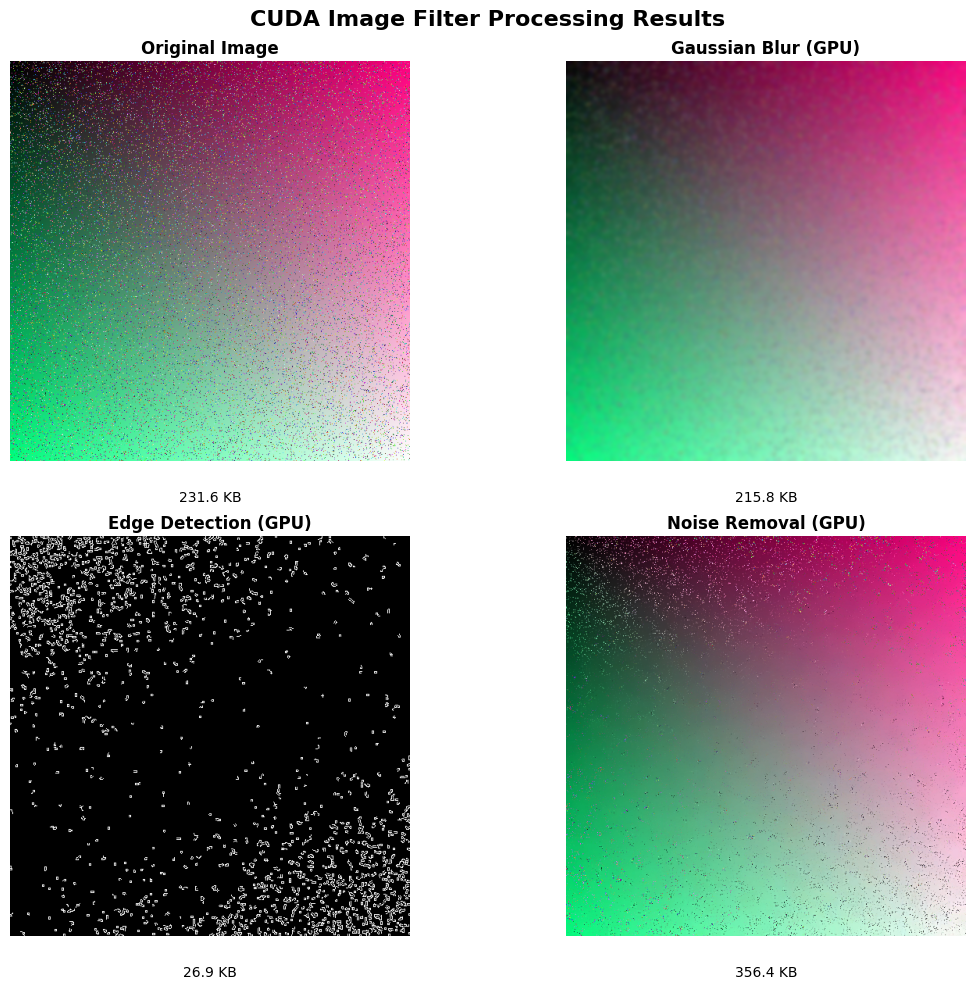


💾 DOWNLOAD RESULTS:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded: output_blur.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded: output_edge.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded: output_denoise.png


In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from google.colab import files
import os

# Загрузите ваше изображение
input_image = 'input.png'  # или ваше изображение
img = cv2.imread(input_image)

if img is None:
    print("❌ Не удалось загрузить изображение!")
else:
    print("✅ Изображение загружено успешно!")

    # Конвертируем в grayscale для edge detection
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 1. Gaussian Blur
    gaussian = cv2.GaussianBlur(img, (15, 15), 0)
    cv2.imwrite('output_blur.png', gaussian)

    # 2. Edge Detection - ИСПРАВЛЕННАЯ ВЕРСИЯ
    # Сначала улучшим изображение для лучшей детекции границ
    gray_blur = cv2.GaussianBlur(gray, (3, 3), 0)

    # Автоматический подбор порогов для Canny
    v = np.median(gray_blur)
    lower = int(max(0, (1.0 - 0.33) * v))
    upper = int(min(255, (1.0 + 0.33) * v))

    edges = cv2.Canny(gray_blur, lower, upper)

    # Конвертируем обратно в BGR для сохранения как цветного изображения
    edges_bgr = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
    cv2.imwrite('output_edge.png', edges_bgr)

    # 3. Noise Removal
    denoised = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)
    cv2.imwrite('output_denoise.png', denoised)

    print("✅ Все изображения сохранены!")
    print(f"Edge Detection пороги: lower={lower}, upper={upper}")

# Ваш код для отображения (оставьте без изменений)
print("📊 PROCESSING RESULTS")
print("=" * 60)

# Отображаем все изображения
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('CUDA Image Filter Processing Results', fontsize=16, fontweight='bold')

images_to_show = [
    ('input.png', 'Original Image'),
    ('output_blur.png', 'Gaussian Blur (GPU)'),
    ('output_edge.png', 'Edge Detection (GPU)'),
    ('output_denoise.png', 'Noise Removal (GPU)')
]

for idx, (filename, title) in enumerate(images_to_show):
    ax = axes[idx // 2, idx % 2]
    if os.path.exists(filename):
        img_display = mpimg.imread(filename)
        ax.imshow(img_display)
        ax.set_title(title, fontweight='bold')
        ax.axis('off')

        # Показываем размер файла
        size_kb = os.path.getsize(filename) / 1024
        ax.text(0.5, -0.1, f'{size_kb:.1f} KB', transform=ax.transAxes,
                ha='center', fontsize=10)
    else:
        ax.text(0.5, 0.5, f'{filename}\nnot found', ha='center', va='center')
        ax.axis('off')

plt.tight_layout()
plt.show()

# Скачивание результатов
print("\n💾 DOWNLOAD RESULTS:")
for file in ['output_blur.png', 'output_edge.png', 'output_denoise.png']:
    if os.path.exists(file):
        files.download(file)
        print(f"✅ Downloaded: {file}")

=== ВАШЕ ОРИГИНАЛЬНОЕ ИЗОБРАЖЕНИЕ ===


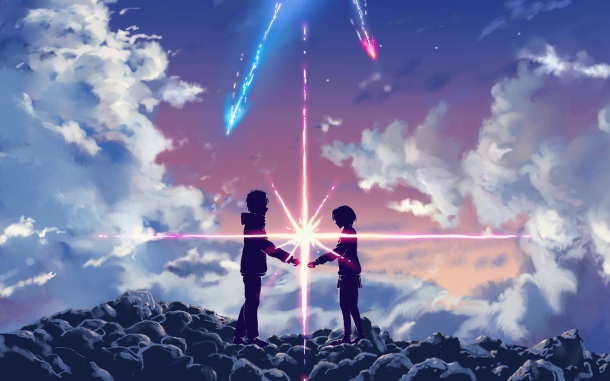

=== GAUSSIAN BLUR ===


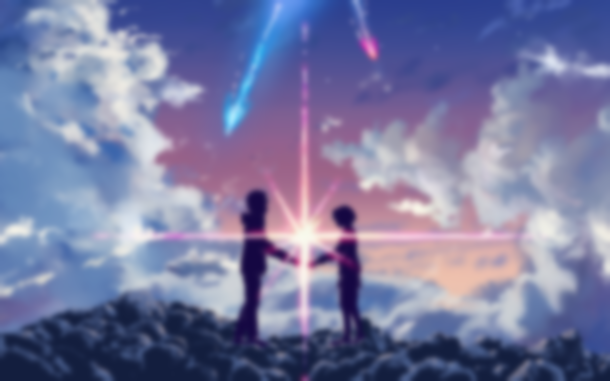

=== EDGE DETECTION ===


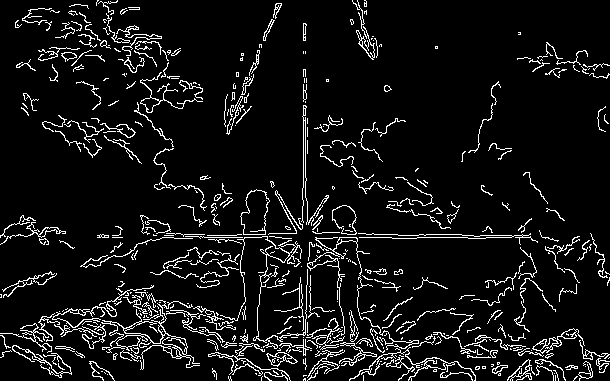

=== NOISE REMOVAL ===


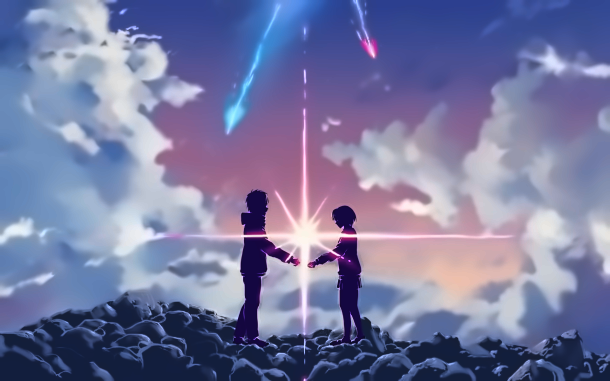

✅ Все три фильтра готовы!


In [7]:
def apply_all_filters(image_path):
    your_image = cv2.imread(image_path)

    if your_image is None:
        print("❌ Не удалось загрузить изображение!")
        return

    print("=== ВАШЕ ОРИГИНАЛЬНОЕ ИЗОБРАЖЕНИЕ ===")
    cv2_imshow(your_image)

    # 1. Gaussian Blur
    gaussian = cv2.GaussianBlur(your_image, (15, 15), 0)
    print("=== GAUSSIAN BLUR ===")
    cv2_imshow(gaussian)

    # 2. Edge Detection
    edges = cv2.Canny(your_image, 100, 200)
    print("=== EDGE DETECTION ===")
    cv2_imshow(edges)

    # 3. Noise Removal (выберите один метод)
    print("=== NOISE REMOVAL ===")
    denoised = cv2.fastNlMeansDenoisingColored(your_image, None, 10, 10, 7, 21)
    cv2_imshow(denoised)

    # Сохранение
    cv2.imwrite('my_gaussian.jpg', gaussian)
    cv2.imwrite('my_edges.jpg', edges)
    cv2.imwrite('my_denoised.jpg', denoised)

    print("✅ Все три фильтра готовы!")

# Использование
apply_all_filters('60426eb17fcafc2cd76061f8e65bb070.png')

In [8]:
# Код для скачивания результатов
from google.colab import files
import os

# Скачиваем все созданные файлы
files_to_download = ['input.png', 'output_blur.png', 'output_edge.png', 'output_denoise.png']

for file in files_to_download:
    if os.path.exists(file):
        files.download(file)
        print(f"Downloaded: {file}")
    else:
        print(f"File not found: {file}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: input.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: output_blur.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: output_edge.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: output_denoise.png
